In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as q

# Parametric Driving 

THIS IS NOTE DONE YET

In [3]:
# Let's start by defining a fluxonium
inp_yaml = """
branches:
- [JJ, 1, 2, 4, 0.5]
- [L, 1, 2, 1.3]
"""
circ = scq.Circuit(inp_yaml, from_file=False, is_flux_dynamic=True, ext_basis="discretized")
circ.cutoff_ext_1 = 100
circ.Φ1 = 0.5

In [4]:
eigs = circ.eigenvals()
eigs - eigs[0]

array([0.        , 0.27506462, 2.65382963, 4.29143957, 6.54828447,
       8.92613973])

Spectral data:   0%|          | 0/41 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Φ1', ylabel='energy [GHz]'>)

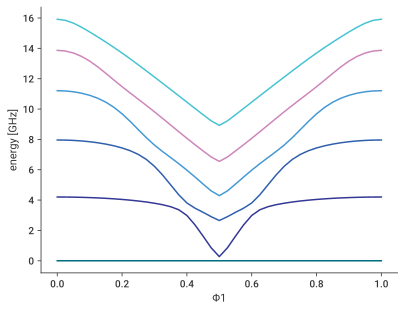

In [5]:
circ.plot_evals_vs_paramvals("Φ1", np.linspace(0, 1, 41), subtract_ground=True)

# Rabi oscillations

In [36]:
# defining Hierarchical diagonalization to limit to the lowest two states
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[10])

def flux_ac(t, args):
        freq = args["freq"]
        return 0.001*np.sin(2*np.pi*freq*t)

# asking the method to return Hamiltonian when Φ1 is varied around the bias point 
H_mesolve, *H_sym_ref = circ.hamiltonian_for_mesolve(free_var_func_dict={"Φ1": flux_ac}, prefactor=np.pi*2)
# H_mesolve is the Hamiltonian to be used in the Qutip method mesolve

eigs, evecs = circ.eigensys(evals_count=5)
wf0 = qt.Qobj(evecs[:, 0]) # ground state as initial state
initial_state_proj = wf0 * wf0.dag() # to see the overlap
tf = 100 # final time in nanoseconds
freq = eigs[1] - eigs[0] # transition frequency between the first two states
result = qt.mesolve(H_mesolve, wf0, np.linspace(0, tf, 500), args={"freq": freq}, e_ops=[initial_state_proj])

Text(0, 0.5, 'Ground state population')

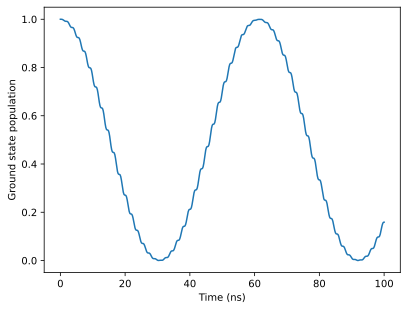

In [38]:
plt.plot(result.times, result.expect[0])
plt.xlabel('Time (ns)')
plt.ylabel('Ground state population')

Note that the steps like features over the sinusiod in the above plot, is because we have not used RWA in the drive Hamiltonian. 

## Example Floquet Simulation

Text(0, 0.5, 'Floquet energies (GHz)')

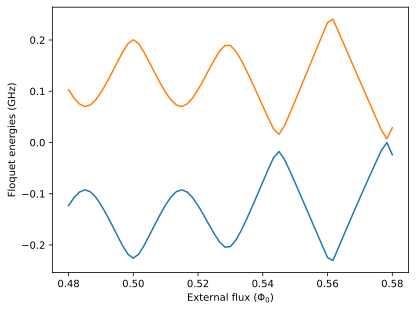

In [56]:
# defining Hierarchical diagonalization to limit to the lowest two states
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[2])

all_eigs = []
flux_vals = np.linspace(0.48, 0.58, 61)
for flux in flux_vals:
    
    circ.Φ1 = flux
    eigs, evecs = circ.eigensys(evals_count=2)
    psi0 = qt.Qobj(evecs[:, 0])
    freq = 491e-3
    
    def flux_ac(t, args):
        freq = args["freq"]
        return 0.028*np.cos(2*np.pi*freq*t)
    
    t = np.linspace(0, 1/freq, 300)
    H_mesolve, *b = circ.hamiltonian_for_mesolve(free_var_func_dict={"Φ1": flux_ac}, prefactor=np.pi*2)
    # calculating the floquet energies
    res = qt.propagator(H_mesolve, t=t, args={"freq": freq})
    u_eigs = res[-1].eigenenergies()
    floquet_eigs = np.arctan2(np.real(u_eigs), np.imag(u_eigs))
    floquet_eigs.sort()
    floquet_eigs = floquet_eigs * freq / (2*np.pi)
    all_eigs.append(floquet_eigs)

plt.plot(flux_vals, all_eigs)
plt.xlabel(r'External flux ($\Phi_0$)')
plt.ylabel('Floquet energies (GHz)')

# Time dependent flux allocation

In [14]:
# Snail for example
inp_yaml = """
branches:
- [JJ, 1, 2, 90, EC1=0.2]
- [JJ, 2, 3, 90, EC3=0.2]
- [JJ, 3, 0, 90, 0.2]
- [JJ, 1, 0, 15, 0.2]
- [C, 1, 0, EC1]
"""
circ = scq.Circuit(inp_yaml, from_file=False)
circ

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Circuit_8

In [15]:
circ.closure_branches

[Branch(JJ, 2, 3, id_str: 1)]

In [16]:
circ = scq.Circuit(inp_yaml, from_file=False, is_flux_dynamic=True)
circ

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Circuit_9

In [17]:
circ.closure_branches

[Branch(JJ, 2, 3, id_str: 1)]

# Coherence time calculations

In [11]:
yaml_inp = """branches:
- [JJ, 1, 2, EJ=30, 1.2]
- [L, 1, 2, 0.1]
"""
circ = scq.Circuit(yaml_inp, from_file=False, ext_basis="harmonic", is_flux_dynamic=True)
circ.cutoff_ext_1 = 100
circ.Φ1 = 0.5
eigs = circ.eigenvals()
print("First transition: ",  eigs[1] - eigs[0])
circ.generate_all_noise_methods() # generating all the methods needed for noise

First transition:  0.00024736471601016774
Supported noise channels: ['t1_capacitive', 't1_charge_impedance', 't1_inductive', 'tphi_1_over_f_flux', 't1_flux_bias_line', 'tphi_1_over_f_cc']


Spectral data:   0%|          | 0/41 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 't1_effective'}, xlabel='Φ1', ylabel='$ns$'>)

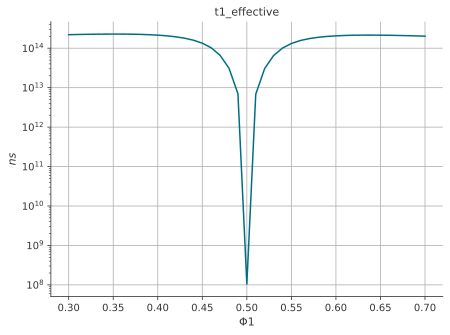

In [61]:
circ.plot_t1_effective_vs_paramvals("Φ1", np.linspace(0.3, 0.7, 41))

Spectral data:   0%|          | 0/41 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 't2_effective'}, xlabel='Φ1', ylabel='$ns$'>)

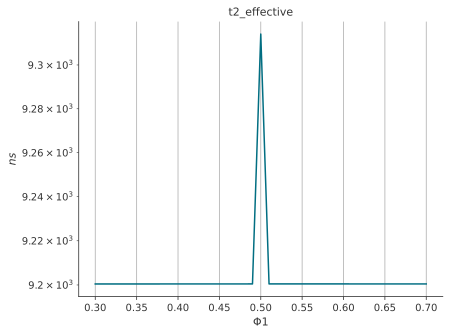

In [62]:
circ.plot_t2_effective_vs_paramvals("Φ1", np.linspace(0.3, 0.7, 41))

The quality factor for a capacitance are defined by the following formula by default

$$Q_{\rm cap}(\omega, T) =  10^{6}  \left( \frac{2 \pi \times 6 {\rm GHz} }{ |\omega|} \right)^{0.7}.$$

Where as the quality factor for an inductor is defined by:

$$Q_{\rm ind}(\omega, T) =  500 \times 10^{6} \frac{ K_{0} \left( \frac{h \times 0.5 {\rm GHz}}{2 k_B T} \right)
\sinh \left( \frac{h \times 0.5 {\rm GHz} }{2 k_B T} \right)}{K_{0} \left( \frac{\hbar |\omega|}{2 k_B T} \right)\
\sinh \left( \frac{\hbar |\omega| }{2 k_B T} \right)}.$$

It is possible that in a circuit a given capacitance might not follow the same expression of quality factors. In that case, the user can define the quality factor, for a capacitance for example, in the following way. Where the expression for the quality factor is given as a string. The functions from `numpy` (using `np.method_name`) and `scqubits.units` (using `units.method_name`) are available to use in the expression. This expression is given as an input to a branch containing a capacitance using an auxiliary parameter `Q_cap`, any folloiwng noise calculations will take the expression for the quality factor given as an input. If this auxiliary parameter is set to a constant `Q_ind=1e5`, the default of $10^6$ used in the above two expressions is substituted with the given constant. Instead, if one wishes to set the quality factor to a constant for all frequencies, one can set it as `Q_ind="1e7"`.

In [4]:
Q_expr = "(1e9 * (2 * np.pi * 6e9 / np.abs(units.to_standard_units(omega))) ** 0.3)"
    
yaml_inp = f"""
branches:
- [JJ, 1, 2, EJ=30, 1.2, Q_cap={Q_expr}]
- [L, 1, 2, 0.1, Q_ind=1e6]
"""
circ = scq.Circuit(yaml_inp, from_file=False, ext_basis="harmonic", is_flux_dynamic=True)
circ.cutoff_ext_1 = 100
eigs = circ.eigenvals()
print("First transition: ",  eigs[1] - eigs[0])
circ.generate_all_noise_methods() # generating all the methods needed for noise

First transition:  1.9664911922119508
Supported noise channels: ['t1_capacitive', 't1_charge_impedance', 't1_inductive', 'tphi_1_over_f_flux', 't1_flux_bias_line', 'tphi_1_over_f_cc']


In [7]:
circ.t1_effective(), circ.t2_effective()

(3.227806741768668e+29, 1147386289.8740897)

# Inputing branch parameters using physical units

The branch parameters can now be entered using physical units prepended by a multiplier. Any branch parameter can be gievn as energy with the units: $Hz$, $J$ or $eV$. Though, each of the branch parameter can be entered with its own unit as well, as listed in the following table.

| Parameter   | Units       |
| ----------- | ----------- |
| C           | F           |
| L           | H           |
| EJ          | A           |

The above units can be prepended with the following multipliers:

| Multiplier  | Value       |
| ----------- | ----------- |
| f           | $10^{-15}$  |
| p           | $10^{-12}$  |
| n           | $10^{-9}$   |
| u           | $10^{-6}$   |
| m           | $10^{-3}$   |
| k           | $10^{3}$    |
| M           | $10^{6}$    |
| G           | $10^{9}$    |
| T           | $10^{12}$   |

For example the inductance of a branch can be given as `1uH`, and Josephson junction energy can be given as `1uA` or `40eV`. If no units are provided the default unit is $GHz$.

In [10]:
yaml_inp = """branches:
- [JJ, 1, 2, EJ=30uA, 1.2fF]
- [L, 1, 2, 500pH]
"""
circ = scq.Circuit(yaml_inp, from_file=False, ext_basis="harmonic", is_flux_dynamic=True)
circ.cutoff_ext_1 = 100
circ.Φ1 = 0.5
eigs = circ.eigenvals()
eigs - eigs[0]

array([0.00000000e+00, 5.05991920e-07, 1.38461790e+03, 1.38461801e+03,
       2.75288383e+03, 2.75288890e+03])

# Chosing basis states for each of the subsystems

When hierarchical diagonalization is used a Circuit instance, one can now choose a separate set of basis states for each of the subsystem. 

In [ ]:
full_yaml = f"""branches:
- [JJ, 0, 1, 10, 2.5]
- [L, 2, 1, 0.5]
- [L, 0 , 2 , 10]
### coupling element
- [C, 2, 3, 5]
### tunable resonator
- [JJ, 0, 3, 50, 2]
- [C, 3, 4, 0.5]
- [L, 4, 0, 8]
"""

circ = scq.Circuit(full_yaml, from_file=False, ext_basis="discretized")
trans_mat = np.array([[1, 0, 0, 0], 
                      [0, 1, 0, 0], 
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
circ.configure(transformation_matrix=trans_mat, closure_branches=[circ.branches[0], circ.branches[-1]]) # chosing a transformation matrix, and closure branches for the two loops.
circ._configure(system_hierarchy=[[[1], [2]], [3, 4]], subsystem_trunc_dims=[[10, [10, 10]], 20], ext_basis=[["harmonic", "discretized"], "discretized"])
